In [1]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
import scipy
from time import time

from oracle import Oracle, make_oracle
from oracle import diff_grad, diff_hessian, hess_grad_test

from line_search import line_search_golden
from line_search import line_search_brent
from line_search import line_search_wolf
from line_search import line_search_nesterov
from line_search import line_search_armijo

from optimize_methods import optimize_gd
from optimize_methods import optimize_newton
from optimize_methods import hfn_optimize

from optimize_methods import eta1, eta2, eta3, eta4, eta5

In [2]:
def six_plots(res, true_val, names=None, compare_name="параметров"):

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(17,6))
    for i in range(len(res)):
        ax1.plot(res[i][2], [np.log10(abs(x[0] - true_val)) for x in res[i][1]])                  
    ax1.legend(names)
    ax1.set_ylabel("log(|L(w) - L(w*)|)")
    ax1.set_xlabel("iteration")
    ax1.set_title("Сходимость от итераций для разных " + compare_name)
    ax1.grid(which='both',
            color = 'gray',
            linestyle = ':')
  
    for i in range(len(res)):
        ax2.plot(res[i][2], np.log10(np.abs(res[i][5])))
                    
    ax2.legend(names)
    ax2.set_ylabel("log(|grad(L(w)) / grad(L(w_0)|)")
    ax2.set_xlabel("iteration")
    ax2.set_title("Сходимость от итераций для разных " + compare_name)
    ax2.grid(which='both',
            color = 'gray',
            linestyle = ':')
    f.show()


    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize=(17,6))
    for i in range(len(res)):
        ax1.plot(res[i][3], [np.log10(abs(x[0] - true_val)) for x in res[i][1]])                  
    ax1.legend(names)
    ax1.set_ylabel("log(|L(w) - L(w*)|)")
    ax1.set_xlabel("oracle calls")
    ax1.set_title("Сходимость от вызовов оракула для разных " + compare_name)
    ax1.grid(which='both',
            color = 'gray',
            linestyle = ':')
  
    for i in range(len(res)):
        ax2.plot(res[i][3], np.log10(np.abs(res[i][5])))
                    
    ax2.legend(names)
    ax2.set_ylabel("log(|grad(L(w)) / grad(L(w_0)|)")
    ax2.set_xlabel("oracle calls")
    ax2.set_title("Сходимость от вызовов оракула для разных " + compare_name)
    ax2.grid(which='both',
            color = 'gray',
            linestyle = ':')
    f.show()



    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize=(17,6))
    for i in range(len(res)):
        ax1.plot(res[i][4], [np.log10(abs(x[0] - true_val)) for x in res[i][1]])                  
    ax1.legend(names)
    ax1.set_ylabel("log(|L(w) - L(w*)|)")
    ax1.set_xlabel("time, s")
    ax1.set_title("Сходимость от времени для разных " + compare_name)
    ax1.grid(which='both',
            color = 'gray',
            linestyle = ':')
  
    for i in range(len(res)):
        ax2.plot(res[i][4], np.log10(np.abs(res[i][5])))
                    
    ax2.legend(names)
    ax2.set_ylabel("log(|grad(L(w)) / grad(L(w_0)|)")
    ax2.set_xlabel("time, s")
    ax2.set_title("Сходимость от времени для разных " + compare_name)
    ax2.grid(which='both',
            color = 'gray',
            linestyle = ':')
    f.show()

In [3]:
def one_plot(res, true_val, names, par="параметров"):
    for i in range(len(res)):
        val = res[i][1][-1][0][0]
        iters = res[i][2][-1]
        or_calls = res[i][3][-1]
        time = res[i][4][-1]
        print("For " + par + "{0}: CE value: {1:1.3f}; oracle calls: {2:3d}; iter_num: {3:2d}; time: {4:1.3f}"\
              .format(names[i], val, or_calls, iters, time)) 
    
    plt.figure(figsize=(6, 4), dpi=100)
    for i in range(len(res)):
        plt.plot(res[i][2], [np.log10(abs(x[0] - true_val)) for x in res[i][1]])
                    
    plt.legend([par + x for x in names])
    plt.ylabel("log(|L(w) - L(w*)|)")
    plt.xlabel("iteration")
    plt.title("Сходимость от итераций для разных " + par)
    plt.grid(which='both',
            color = 'gray',
            linestyle = ':')
    plt.show()

## Пункт 1

Записать задачу в матричном виде, выписать формулы для вычисления
значения функции в векторном виде, а также для для вычисления значения
градиента и гессиана этой функции.

Функция:
$$L(w) = - \dfrac{1}{N} \left(y^T \log(p) + (\textbf{1} - y)^T \log(1 - p)\right),$$
$p = \sigma(Xw)$ - вектор, составленный из $\sigma(x_i^Tw)$

Градиент:
$$\nabla L(w) = - \dfrac{1}{N} X^T (y - p),$$

Гессиан:
$$\nabla^2 L(w) = \dfrac{1}{N} X^T D X,$$

где $D$ -- диагональная матрица, диагональ которой это вектор $p(1 - p)$

Результат работы метода для логистической регрессии от выбора начальной точки зависеть не должен, так как гессиан L положительно определён, а значит L -- выпуклая.

## Пункт 2 

Реализовать оракулы для задачи логистической регрессии:
оракул нулевого порядка (вычисляет функцию), оракул первого порядка
(функцию + градиент) и оракул второго порядка (функция + градиент +
гессиан).

Для реализованных оракулов требуется написать тест, проверяющий
корректность вычисления вычисленных производных с помощью разностного
дифференцирования

In [4]:
oracle1 = make_oracle("a1a.txt")
oracle2 = make_oracle("breast_cancer_scale.txt")

# my dataset
np.random.seed(37)
a, b = 2 * np.random.random(2) - 1
X_ = np.random.normal(loc=0.0, scale=1.0, size=1000).reshape(-1, 1) 
y = ((a * X_ + b) >= 0).astype(int)
X = np.hstack([X_, np.ones(X_.shape[0]).reshape(-1, 1)])
oracle3 = Oracle(X, y)

In [5]:
hess_grad_test(oracle1)

Максимальное значение ошибки приближения градиента:  1.4497542909599256e-07
Максимальное значение ошибки приближения гессиана:  2.196700418076068e-07


In [6]:
hess_grad_test(oracle2)

Максимальное значение ошибки приближения градиента:  2.0556261590698455e-06
Максимальное значение ошибки приближения гессиана:  2.0515472394511125e-07


In [7]:
hess_grad_test(oracle3)

Максимальное значение ошибки приближения градиента:  1.4621381161372682e-08
Максимальное значение ошибки приближения гессиана:  6.8469573899498926e-09


Для градиента и гессиана ошибка получилась порядка $10^{-8}$ - $10^{-6}$, что довольно неплохо.

Получим оптимальное решение $w_{sk}$ c помощью sklearn.

In [8]:
def true_val(oracle):
    clf = LogisticRegression(penalty='none',
                             fit_intercept=False).fit(oracle.X, oracle.y)
    w_sk = clf.coef_[0].reshape(-1, 1)
    true_val = oracle.value(w_sk)[0][0]
    return true_val

In [9]:
true_val1 = true_val(oracle1)
true_val2 = true_val(oracle2)
true_val3 = true_val(oracle3)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

## Пункт 3
Реализовать метод градиентного спуска для произвольного метода
поиска по прямой

Изучить эмпирически скорость работы на нескольких наборах данных следующих стратегий линейного поиска в методе градиентного спуска:

1. наискорейший спуск, в качестве метода одномерной реализации
использовать реализованный вами метод золотого сечения

2. наискорейший спуск с использованием метода Брэнта

3. Неточный поиск шага с использованием условия армихо. 

4. Неточный поиск с условиями Вульфа. 

5. Выбор шага с помошью алгоритма, оценивающего локальную константу
Липшеца (метод Нестерова)


In [10]:
# a1a dataset
oracle = oracle1
line_search_methods = [line_search_golden(), line_search_brent(),
                       line_search_armijo(), line_search_wolf(),
                       line_search_nesterov()]
names = ["ls_golden", "ls_brent", "ls_armijo", "ls_wolf", "ls_nesterov"]
w0 = np.zeros(oracle.X.shape[1]).reshape(-1, 1)
# w0 = np.random.randn(oracle.X.shape[1]).reshape(-1, 1)
# w0 = np.ones(oracle.X.shape[1]).reshape(-1, 1)

res = []
for i in range(len(line_search_methods)):
    start = time()
    print(names[i], "+ GD: START")
    print()
    optimize = optimize_gd()
    w_my = optimize(oracle, w0, line_search_methods[i])
    
    vals = optimize.values
    iters = optimize.iterations
    or_calls = optimize.oracle_calls
    times = optimize.times
    grads = optimize.grads
    
    res.append([w_my, vals, iters, or_calls, times, grads])
    print(names[i], "+ GD: END")
    print("CE value:", oracle.value(w_my).squeeze())
    print("Total oracle calls: ", or_calls[-1])
    print("Time: ", time() - start, "sec")
    print("----------------------------------------------------------")
    print()

ls_golden + GD: START

iteration: 1000
value of CE: 0.3042242536580362
norm(d)^2 / norm(d_0)^2: 1.322746092837916e-05
alpha 6.232524859367529

iteration: 2000
value of CE: 0.3012822351524198
norm(d)^2 / norm(d_0)^2: 4.20358517639773e-06
alpha 6.7407516581348474

iteration: 3000
value of CE: 0.30015006838813835
norm(d)^2 / norm(d_0)^2: 1.9631404953389952e-06
alpha 6.884705062547319

iteration: 4000
value of CE: 0.2995651374274641
norm(d)^2 / norm(d_0)^2: 1.1127389345974434e-06
alpha 7.020257459497614

iteration: 5000
value of CE: 0.29921559907493117
norm(d)^2 / norm(d_0)^2: 7.063623505462139e-07
alpha 7.117626563682959

iteration: 6000
value of CE: 0.29898552455867616
norm(d)^2 / norm(d_0)^2: 4.850656651509692e-07
alpha 7.201402552254757

iteration: 7000
value of CE: 0.298823095899901
norm(d)^2 / norm(d_0)^2: 3.478096243724268e-07
alpha 7.175207925447948

iteration: 8000
value of CE: 0.29870305748184794
norm(d)^2 / norm(d_0)^2: 2.663926503187767e-07
alpha 7.297167206784698

iteration: 9

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


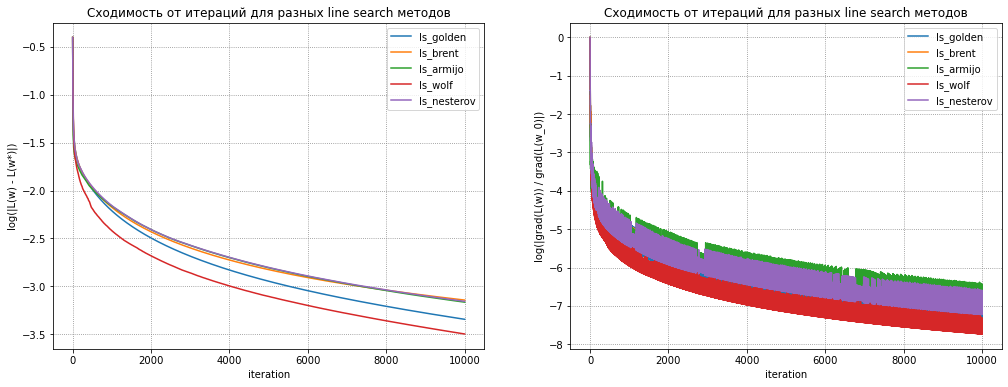

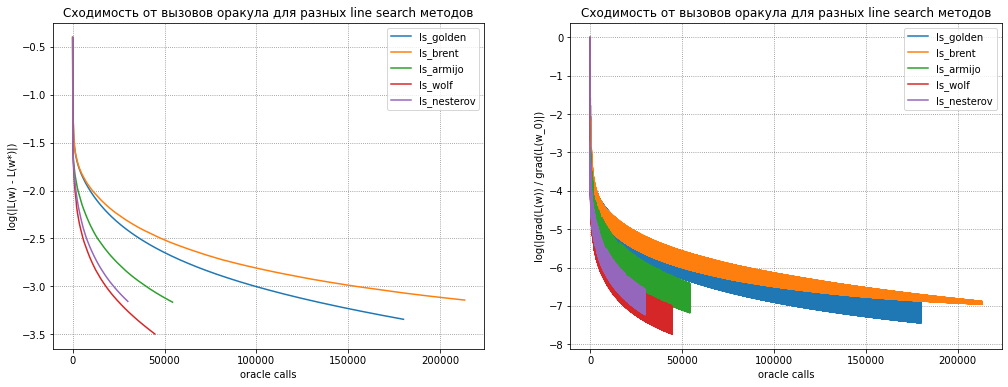

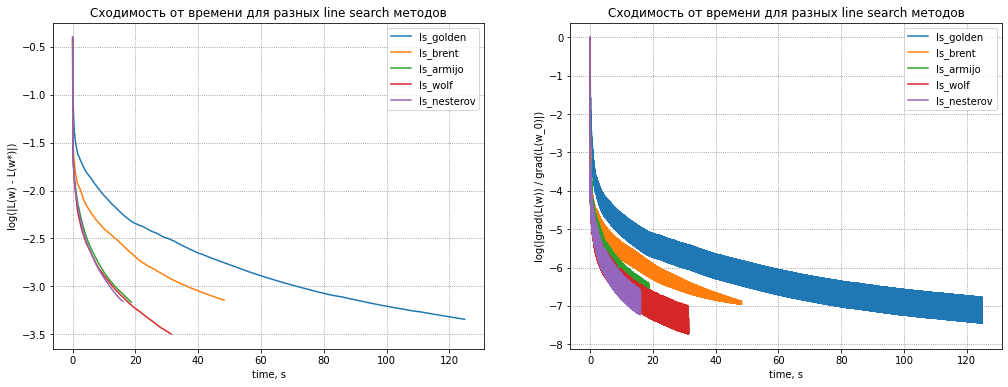

In [11]:
six_plots(res, true_val1, names=names, compare_name="line search методов")

Из графиков видно, что дольше всего GD работал с золотым сечением -- около 2-х минут (это может быть связано с моей реализацией метода золотого сечения). С остальными стратегиями линейного поиска GD отработал быстрее 40 секунд. С Нестеровым и Армихо потребовалось чуть больше 20 сек. Всеми методами была достигнута точность 3 десятичных знаков после запятой. Все методы остановились при достижении максимального числа итераций (10000 итераций). Меньше всего вызовов оракула потребовалось Нестерову (25 тыс.), вульфу и армихо (около 50 тыс.), бренту и золотому сечению более 125 тыс. Сходимость сублинейная.

In [12]:
# bc_sc dataset

oracle = oracle2
line_search_methods = [line_search_golden(), line_search_brent(),
                       line_search_armijo(), line_search_wolf(),
                       line_search_nesterov()]
names = ["ls_golden", "ls_brent", "ls_armijo", "ls_wolf", "ls_nesterov"]
w0 = np.zeros(oracle.X.shape[1]).reshape(-1, 1)
# w0 = np.random.randn(120).reshape(-1, 1)
# w0 = np.ones(oracle.X.shape[1]).reshape(-1, 1)

res = []
for i in range(len(line_search_methods)):
    start = time()
    print(names[i], "+ GD: START")
    print()
    optimize = optimize_gd()
    w_my = optimize(oracle, w0, line_search_methods[i]) 
    
    vals = optimize.values
    iters = optimize.iterations
    or_calls = optimize.oracle_calls
    times = optimize.times
    grads = optimize.grads
    
    res.append([w_my, vals, iters, or_calls, times, grads])
    print(names[i], "+ GD: END")
    print("CE value:", oracle.value(w_my).squeeze())
    print("Total oracle calls: ", or_calls[-1])
    print("Time: ", time() - start, "sec")
    print("----------------------------------------------------------")
    print()

ls_golden + GD: START

ls_golden + GD: END
CE value: 0.07546852286962868
Total oracle calls:  8407
Time:  2.756019115447998 sec
----------------------------------------------------------

ls_brent + GD: START

ls_brent + GD: END
CE value: 0.07545703748466501
Total oracle calls:  6896
Time:  0.8389818668365479 sec
----------------------------------------------------------

ls_armijo + GD: START

ls_armijo + GD: END
CE value: 0.07546369207938397
Total oracle calls:  2172
Time:  0.3059988021850586 sec
----------------------------------------------------------

ls_wolf + GD: START

ls_wolf + GD: END
CE value: 0.07546794145432717
Total oracle calls:  1850
Time:  0.6549990177154541 sec
----------------------------------------------------------

ls_nesterov + GD: START

ls_nesterov + GD: END
CE value: 0.07546482719339832
Total oracle calls:  884
Time:  0.25102829933166504 sec
----------------------------------------------------------



C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


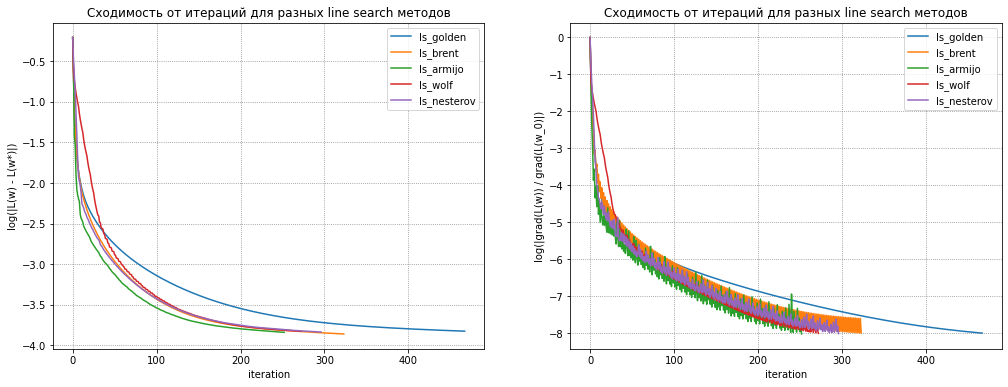

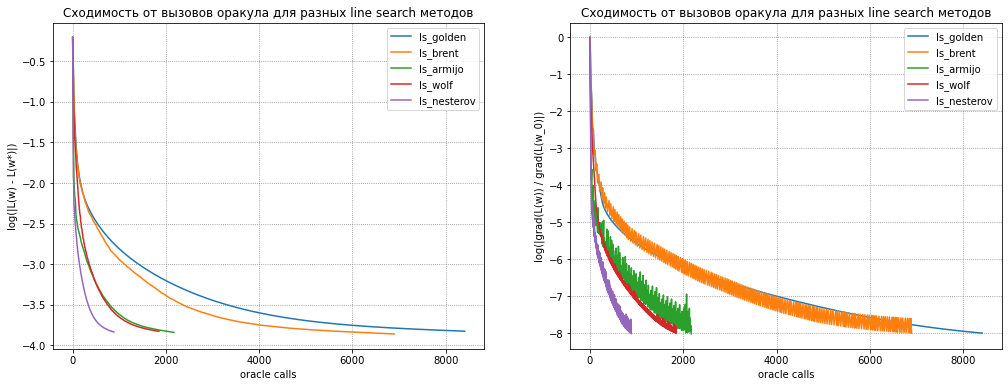

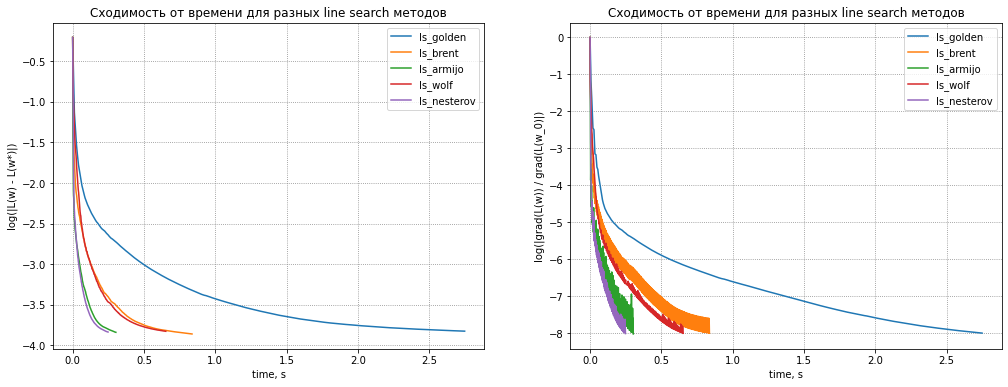

In [13]:
six_plots(res, true_val2, names=names, compare_name="line search методов")

Датасет поменьше. Из графиков видно, что дольше всего GD работал с золотым сечением -- около 4-х секунд, с остальными стратегиями линейного поиска GD отработал быстрее, чем за секунду. Всеми методами была достигнута точность 3 десятичных знаков после запятой. Всем методам потребовалось от 200 до 300 итераций, только золотому сечению более 400. Меньше всего вызовов оракула снова потребовалось Нестерову (около тысячи), Армихо и Вульфу (около 2000), бренту и золотому сечению более 4 тыс. Сходимость сублинейная.

In [14]:
# random dataset

oracle = oracle3
line_search_methods = [line_search_golden(), line_search_brent(),
                       line_search_armijo(), line_search_wolf(),
                       line_search_nesterov()]
names = ["ls_golden", "ls_brent", "ls_armijo", "ls_wolf", "ls_nesterov"]
# w0 = np.zeros(oracle.X.shape[1]).reshape(-1, 1)
w0 = np.random.randn(oracle.X.shape[1]).reshape(-1, 1)
# w0 = np.ones(oracle.X.shape[1]).reshape(-1, 1)

res = []
for i in range(len(line_search_methods)):
    start = time()
    print(names[i], "+ GD: START")
    print()
    optimize = optimize_gd()
    w_my = optimize(oracle, w0, line_search_methods[i]) 
    
    vals = optimize.values
    iters = optimize.iterations
    or_calls = optimize.oracle_calls
    times = optimize.times
    grads = optimize.grads
    
    res.append([w_my, vals, iters, or_calls, times, grads])
    print(names[i], "+ GD: END")
    print("CE value:", oracle.value(w_my).squeeze())
    print("Total oracle calls: ", or_calls[-1])
    print("Time: ", time() - start, "sec")
    print("----------------------------------------------------------")
    print()

ls_golden + GD: START

iteration: 1000
value of CE: 0.022506406838925075
norm(d)^2 / norm(d_0)^2: 2.5795719755686894e-06
alpha 14.995799496268914

iteration: 2000
value of CE: 0.017701811502817896
norm(d)^2 / norm(d_0)^2: 1.058011713024747e-06
alpha 14.995799496268914

iteration: 3000
value of CE: 0.015303492338008755
norm(d)^2 / norm(d_0)^2: 6.275647661631991e-07
alpha 14.995799496268914

iteration: 4000
value of CE: 0.013764902623884379
norm(d)^2 / norm(d_0)^2: 4.3276955625385557e-07
alpha 14.995799496268914

iteration: 5000
value of CE: 0.012657887189973115
norm(d)^2 / norm(d_0)^2: 3.2408505763119355e-07
alpha 14.995799496268914

iteration: 6000
value of CE: 0.011806477552878124
norm(d)^2 / norm(d_0)^2: 2.5568290998852455e-07
alpha 14.995799496268914

iteration: 7000
value of CE: 0.011122338546690444
norm(d)^2 / norm(d_0)^2: 2.091098427616353e-07
alpha 14.995799496268914

iteration: 8000
value of CE: 0.010555272955026708
norm(d)^2 / norm(d_0)^2: 1.7558881665645722e-07
alpha 14.99579

C:\Users\User\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\User\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


iteration: 1000
value of CE: 0.006364919014409818
norm(d)^2 / norm(d_0)^2: 3.913062265619612e-08
alpha 512.0

ls_wolf + GD: END
CE value: 0.0042374182824247925
Total oracle calls:  21520
Time:  4.764997482299805 sec
----------------------------------------------------------

ls_nesterov + GD: START

iteration: 1000
value of CE: 0.006606804102141236
norm(d)^2 / norm(d_0)^2: 3.998430783182926e-08
alpha 512.0

ls_nesterov + GD: END
CE value: 0.0040889297692911
Total oracle calls:  5772
Time:  1.2820043563842773 sec
----------------------------------------------------------



C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


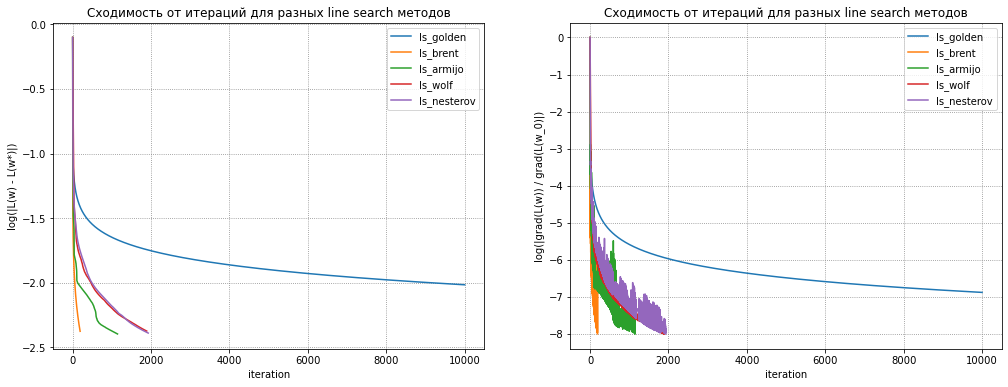

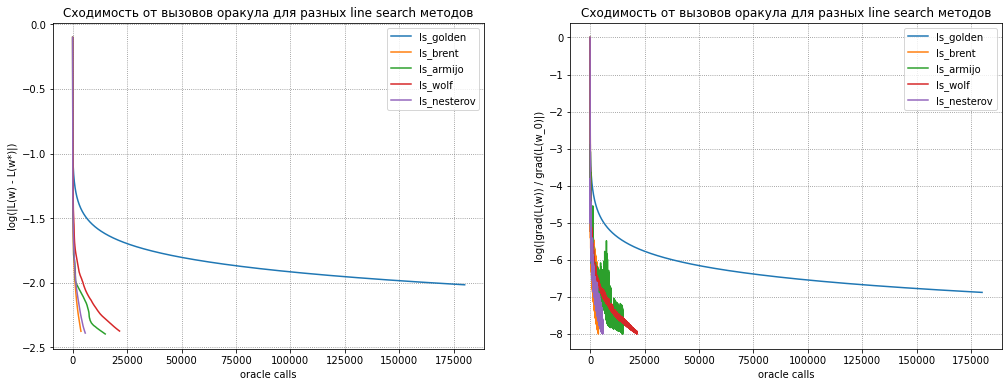

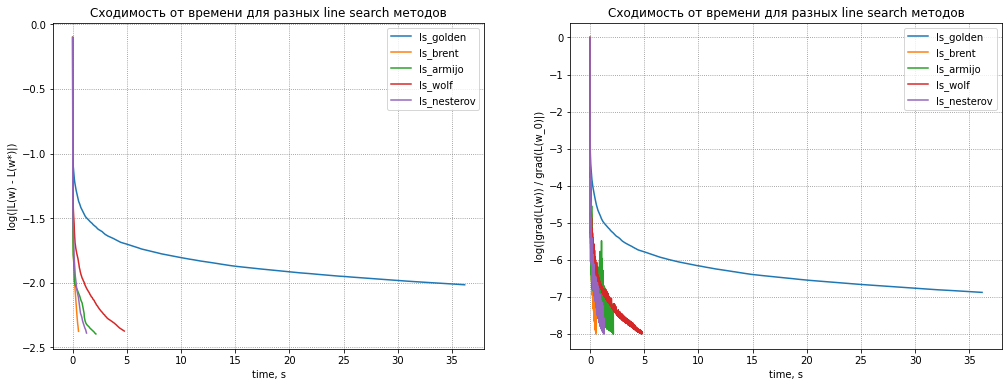

In [15]:
six_plots(res, true_val3, names=names, compare_name="line search методов")

В данном эксперименте хуже всего себя показал метод золотогосечения (более 25 сек, более 175 тыс. обращений к оракулу, 10 тыс итераций). Остальные методы сошлись менее чем за 2 тыс. итераций, 5 сек., с 25 тыс. вызовами оракула. Все методы достишли точности 2-х знаков после запятой. Сходимость сублинейная.

### Параметры Вульфа 

In [16]:
# bc_sc dataset

C1 = [0.7, 0.5, 0.3, 0.1, 0.01, 0.001, 0.0001]
C2 = [0.9, 0.6, 0.3, 0.1]
oracle = oracle2
res_c1 = []

for c1 in C1:
    w0 = np.zeros(oracle.X.shape[1]).reshape(-1, 1)
    optimize = optimize_gd()
    w = optimize(oracle, w0, line_search_wolf(c1=c1))
    res_c1.append((w, optimize.values, optimize.iterations,
                   optimize.oracle_calls, optimize.times))
    
    
res_c2 = []
for c2 in C2:
    w0 = np.zeros(oracle.X.shape[1]).reshape(-1, 1)
    optimize = optimize_gd()
    w = optimize(oracle, w0, line_search_wolf(c2=c2))
    res_c2.append((w, optimize.values, optimize.iterations,
                   optimize.oracle_calls, optimize.times))

For C1 = 0.7: CE value: 0.075; oracle calls: 1861; iter_num: 273; time: 0.659
For C1 = 0.5: CE value: 0.075; oracle calls: 1851; iter_num: 273; time: 0.682
For C1 = 0.3: CE value: 0.075; oracle calls: 1850; iter_num: 272; time: 0.650
For C1 = 0.1: CE value: 0.075; oracle calls: 1850; iter_num: 272; time: 0.646
For C1 = 0.01: CE value: 0.075; oracle calls: 1850; iter_num: 272; time: 0.619
For C1 = 0.001: CE value: 0.075; oracle calls: 1850; iter_num: 272; time: 0.647
For C1 = 0.0001: CE value: 0.075; oracle calls: 1850; iter_num: 272; time: 0.661


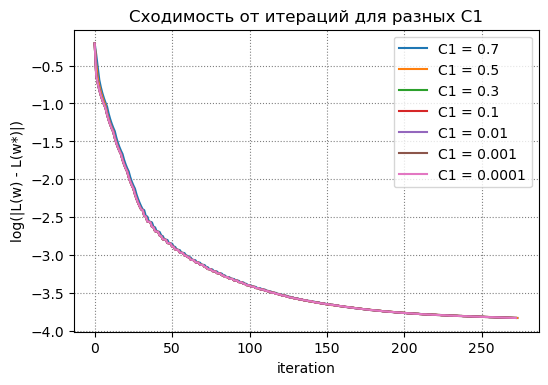

In [17]:
one_plot(res_c1, true_val2, names=list(map(lambda x: " = "+ str(x), C1)), par="C1")

Из эксперимента следует, что варьирование константы $C_1$ не оказывает явного влияния на процесс оптимизации, так как требуемое время, количество итераций, вызовов ракула оказалось одинаково.

For C2 = 0.9: CE value: 0.075; oracle calls: 1850; iter_num: 272; time: 0.638
For C2 = 0.6: CE value: 0.075; oracle calls: 1889; iter_num: 254; time: 0.637
For C2 = 0.3: CE value: 0.075; oracle calls: 2083; iter_num: 271; time: 0.706
For C2 = 0.1: CE value: 0.075; oracle calls: 4378; iter_num: 488; time: 1.478


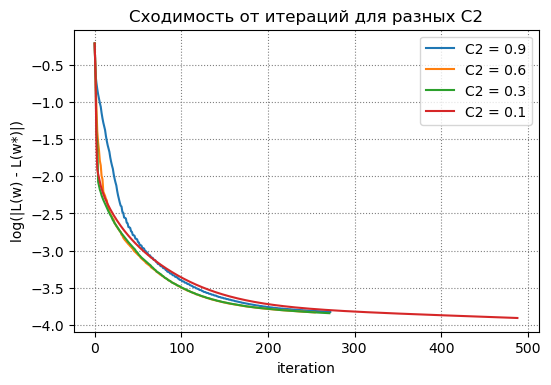

In [18]:
one_plot(res_c2, true_val2, names=list(map(lambda x:  " = "+ str(x), C2)), par="C2")

С парамтром $C_2$ уже можно заметить некоторые зависимости. Так, для малой $C_2 = 0.1$ потребовалось больше итераций, времени и вызовов оракула.

### Параметры Армихо

In [19]:
# bc_sc dataset

C1 = [0.7, 0.5, 0.3, 0.1, 0.01, 0.001, 0.0001]
etas = [2, 5, 7, 10]
oracle = oracle2
res_c1 = []

for c1 in C1:
    w0 = np.zeros(oracle.X.shape[1]).reshape(-1, 1)
    optimize = optimize_gd()
    w = optimize(oracle, w0, line_search_armijo(c1=c1))
    res_c1.append((w, optimize.values, optimize.iterations,
                   optimize.oracle_calls, optimize.times))
    
    
res_eta = []
for eta in etas:
    w0 = np.zeros(oracle.X.shape[1]).reshape(-1, 1)
    optimize = optimize_gd()#.__init__()
    w = optimize(oracle, w0, line_search_armijo(eta=eta))
    res_eta.append((w, optimize.values, optimize.iterations,
                   optimize.oracle_calls, optimize.times))

For C1 = 0.7: CE value: 0.075; oracle calls: 2050; iter_num: 244; time: 0.315
For C1 = 0.5: CE value: 0.075; oracle calls: 2180; iter_num: 258; time: 0.316
For C1 = 0.3: CE value: 0.075; oracle calls: 2358; iter_num: 274; time: 0.350
For C1 = 0.1: CE value: 0.075; oracle calls: 2185; iter_num: 253; time: 0.300
For C1 = 0.01: CE value: 0.075; oracle calls: 2733; iter_num: 317; time: 0.360
For C1 = 0.001: CE value: 0.075; oracle calls: 2817; iter_num: 327; time: 0.372
For C1 = 0.0001: CE value: 0.075; oracle calls: 2921; iter_num: 339; time: 0.379


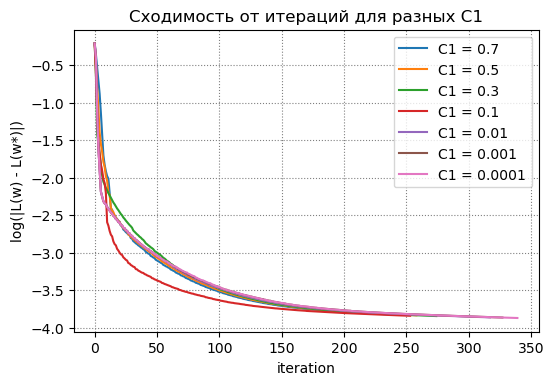

In [20]:
one_plot(res_c1, true_val2, names=list(map(lambda x: " = "+ str(x), C1)), par="C1")

Эксперимент показывает, что параметр $c_1$ не оказывает существенного влияния на процесс оптимизации. Можно лишь заметить, что с уменьшением $c_1$ требуемое время и количество итераций увеличивается.

For eta = 2: CE value: 0.075; oracle calls: 2172; iter_num: 252; time: 0.283
For eta = 5: CE value: 0.075; oracle calls: 2736; iter_num: 476; time: 0.435
For eta = 7: CE value: 0.075; oracle calls: 1597; iter_num: 294; time: 0.289
For eta = 10: CE value: 0.075; oracle calls: 460; iter_num: 85; time: 0.090


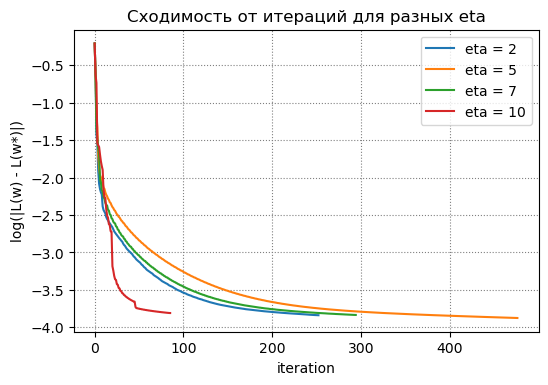

In [21]:
one_plot(res_eta, true_val2, names=list(map(lambda x: " = "+ str(x), etas)), par="eta")

В данном эксперименте можно заметить, что увеличение параметра $\eta$ привело к сокращению числа итераций, вызовов оракула и времени. В частности, меньше всего итераций потребовалось при $\eta = 10$.

Эксперименты показали, что большой недостаток метода GD -- долгое время работы на не квадратичных функциях. 

## Пункт 4 

Реализовать метод Ньютона. Провести аналогичные прошлому
пункту (т.е. все) исследования по стратегиям выбора шага для реализованного
метода, кроме оценки константы Липшица

In [22]:
oracle = oracle1
line_search_methods = [line_search_golden(), line_search_brent(),
                       line_search_armijo(), line_search_wolf()]
names = ["ls_golden", "ls_brent", "ls_armijo", "ls_wolf"]

w0 = np.zeros(oracle.X.shape[1]).reshape(-1, 1)
# w0 = np.random.randn(120).reshape(-1, 1)
# w0 = np.ones(oracle.X.shape[1]).reshape(-1, 1)

res = []
for i in range(len(line_search_methods)):
    start = time()
    print(names[i], "+ Newton: START")
    print()
    
    optimize = optimize_newton()
    w_my = optimize(oracle, w0, line_search_methods[i])
    
    vals = optimize.values
    iters = optimize.iterations
    or_calls = optimize.oracle_calls
    times = optimize.times
    grads = optimize.grads
    
    res.append([w_my, vals, iters, or_calls, times, grads])
    print(names[i], "+ Newton: END")
    print("CE value:", oracle.value(w_my).squeeze())
    print("Total oracle calls: ", or_calls[-1])
    print("Time: ", time() - start, "sec")
    print("----------------------------------------------------------")
    print()

ls_golden + Newton: START

iteration: 1
value of CE: 0.3149905856699318
norm(grad)^2 / norm(grad_0)^2: 0.004553467717803355
alpha 1.962345562925863

iteration: 2
value of CE: 0.30080048389571096
norm(grad)^2 / norm(grad_0)^2: 0.0010201992298047116
alpha 1.0950374779550676

iteration: 3
value of CE: 0.2984618150043752
norm(grad)^2 / norm(grad_0)^2: 8.676011463538784e-05
alpha 1.5430868608817132

iteration: 4
value of CE: 0.2980248092099221
norm(grad)^2 / norm(grad_0)^2: 3.5665058850534965e-05
alpha 1.499098614730268

iteration: 5
value of CE: 0.2979112458319658
norm(grad)^2 / norm(grad_0)^2: 7.394899785122959e-06
alpha 1.5074996221924466

iteration: 6
value of CE: 0.2978842198995845
norm(grad)^2 / norm(grad_0)^2: 1.9216209114136893e-06
alpha 1.4855054991167242

iteration: 7
value of CE: 0.29787769223510346
norm(grad)^2 / norm(grad_0)^2: 4.7070493637361264e-07
alpha 1.5058951725370404

iteration: 8
value of CE: 0.29787613789707246
norm(grad)^2 / norm(grad_0)^2: 1.2897054011514865e-07
alp

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


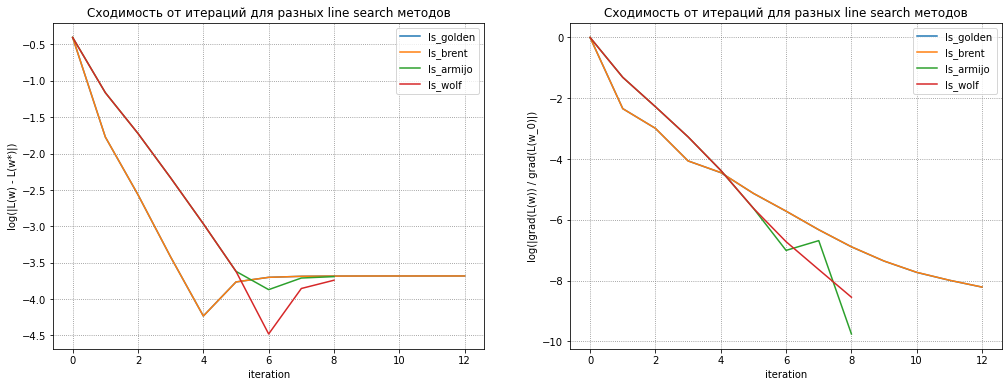

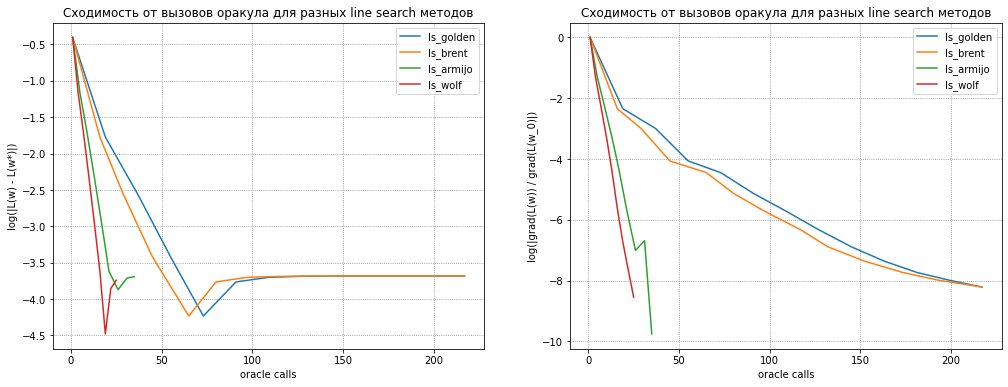

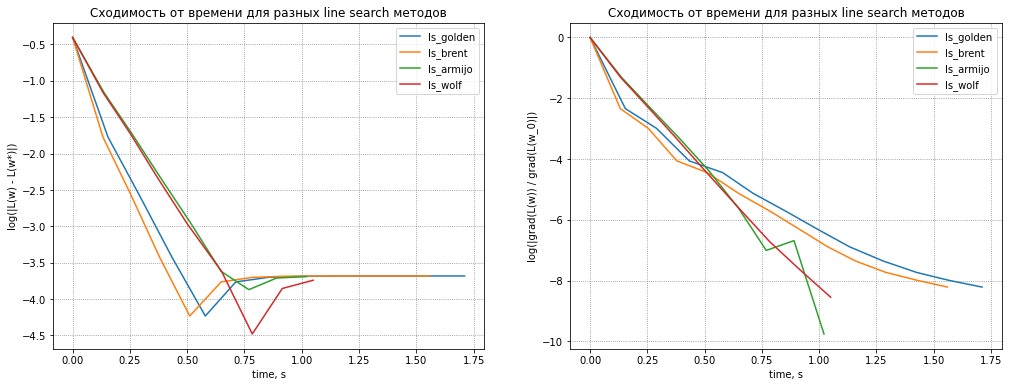

In [23]:
six_plots(res, true_val1, names=names, compare_name="line search методов")

Методам потребовалось не более 12 итераций, около 200 обращений к оракулу и 2 секунды. Что значительно лучше, чем с GD. Была достигнута точность 3-х знаков после запятой. Углы (резкое убывание и возрастание) на графиках слева можно объяснить тем, что критерий остановки в методе Ньютона завязан на отношении норм градиентов, а не на разности значений функции L. 

In [24]:
# bc_sc dataset

oracle = oracle2
line_search_methods = [line_search_golden(), line_search_brent(),
                       line_search_armijo(), line_search_wolf()]
names = ["ls_golden", "ls_brent", "ls_armijo", "ls_wolf"]

w0 = np.zeros(oracle.X.shape[1]).reshape(-1, 1)
# w0 = np.random.rand(oracle.X.shape[1]).reshape(-1, 1)
# w0 = np.ones(oracle.X.shape[1]).reshape(-1, 1)

res = []
for i in range(len(line_search_methods)):
    start = time()
    print(names[i], "+ Newton: START")
    print()
    
    optimize = optimize_newton()
    w_my = optimize(oracle, w0, line_search_methods[i])
    
    vals = optimize.values
    iters = optimize.iterations
    or_calls = optimize.oracle_calls
    times = optimize.times
    grads = optimize.grads
    
    res.append([w_my, vals, iters, or_calls, times, grads])
    print(names[i], "+ Newton: END")
    print("CE value:", oracle.value(w_my).squeeze())
    print("Total oracle calls: ", or_calls[-1])
    print("Time: ", time() - start, "sec")
    print("----------------------------------------------------------")
    print()

ls_golden + Newton: START

iteration: 1
value of CE: 0.0900589976821832
norm(grad)^2 / norm(grad_0)^2: 0.0007983910977411503
alpha 2.780473293593849

iteration: 2
value of CE: 0.07707412135622468
norm(grad)^2 / norm(grad_0)^2: 6.165779375845807e-05
alpha 1.1772090168714624

iteration: 3
value of CE: 0.07536154539996842
norm(grad)^2 / norm(grad_0)^2: 1.002602795723226e-06
alpha 1.421127579544963

iteration: 4
value of CE: 0.07531912265870266
norm(grad)^2 / norm(grad_0)^2: 4.28628179326226e-09
alpha 1.0290551087279

ls_golden + Newton: END
CE value: 0.07531912265870266
Total oracle calls:  73
Time:  0.1329960823059082 sec
----------------------------------------------------------

ls_brent + Newton: START

iteration: 1
value of CE: 0.09005899505852734
norm(grad)^2 / norm(grad_0)^2: 0.0007979926218591494
alpha 2.779996776472668

iteration: 2
value of CE: 0.07707341063718583
norm(grad)^2 / norm(grad_0)^2: 6.111027461144036e-05
alpha 1.1762463664584741

iteration: 3
value of CE: 0.075361572

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


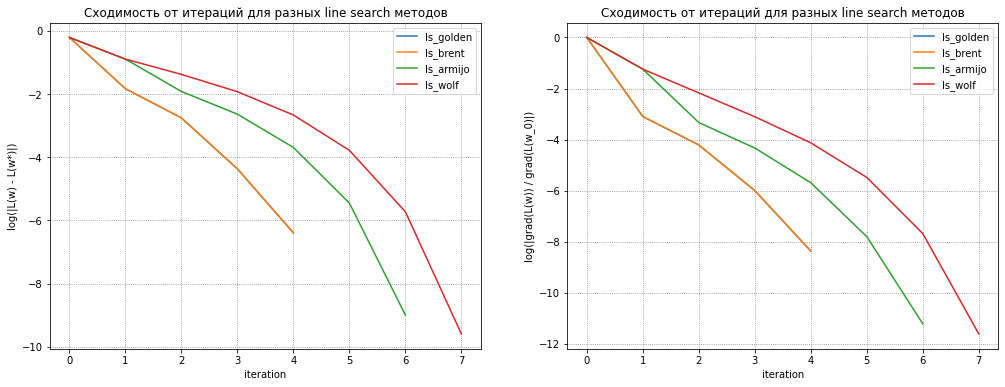

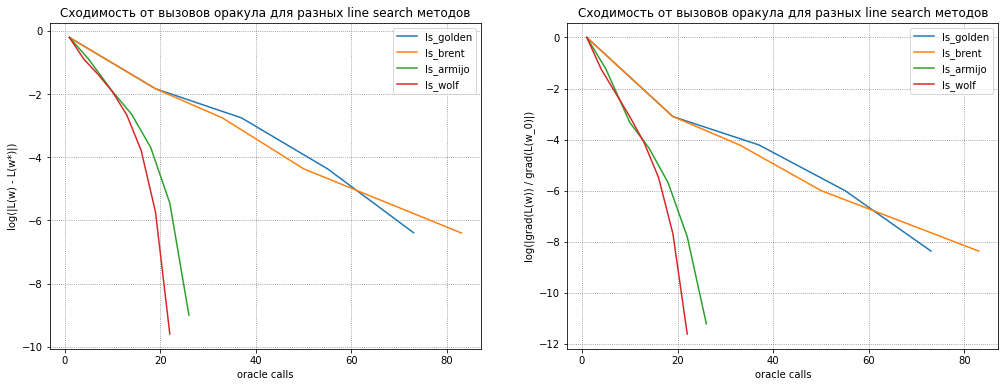

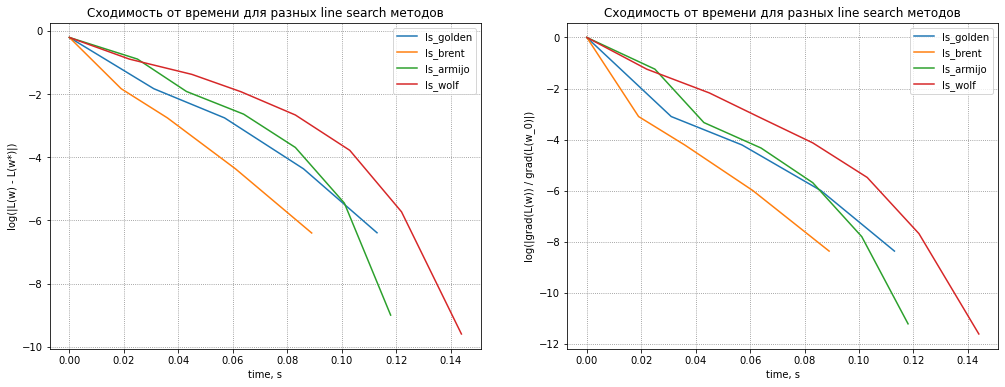

In [25]:
six_plots(res, true_val2, names=names, compare_name="line search методов")

На данном датасете золотое сечение и брент достигли точности 6 знаков после запятой, а остальные методы 8. Методам потребовалось не более 7 итераций, около 200 обращений к оракулу и 2 секунды. Что значительно лучше, чем с GD. Графики соответствуют квадратичной сходимости.

In [26]:
# random dataset
oracle = oracle3
line_search_methods = [line_search_golden(), line_search_brent(),
                       line_search_armijo(), line_search_wolf()]
names = ["ls_golden", "ls_brent", "ls_armijo", "ls_wolf"]

# w0 = np.zeros(oracle.X.shape[1]).reshape(-1, 1)
# w0 = np.random.randn(120).reshape(-1, 1)
w0 = np.ones(oracle.X.shape[1]).reshape(-1, 1)

res = []
for i in range(len(line_search_methods)):
    start = time()
    print(names[i], "+ Newton: START")
    print()
    
    optimize = optimize_newton()
    w_my = optimize(oracle, w0, line_search_methods[i])
    
    vals = optimize.values
    iters = optimize.iterations
    or_calls = optimize.oracle_calls
    times = optimize.times
    grads = optimize.grads
    
    res.append([w_my, vals, iters, or_calls, times, grads])
    print(names[i], "+ Newton: END")
    print("CE value:", oracle.value(w_my).squeeze())
    print("Total oracle calls: ", or_calls[-1])
    print("Time: ", time() - start, "sec")
    print("----------------------------------------------------------")
    print()

ls_golden + Newton: START

iteration: 1
value of CE: 0.20044926515131414
norm(grad)^2 / norm(grad_0)^2: 0.07224035160929683
alpha 2.066511224917981

iteration: 2
value of CE: 0.07280918528132758
norm(grad)^2 / norm(grad_0)^2: 0.010510294911620584
alpha 4.150816069180595

iteration: 3
value of CE: 0.03198147202007282
norm(grad)^2 / norm(grad_0)^2: 0.0011534573070705926
alpha 2.658514012257099

iteration: 4
value of CE: 0.01200892680775382
norm(grad)^2 / norm(grad_0)^2: 0.0003266603597477239
alpha 4.086438149608835

iteration: 5
value of CE: 0.003707805614197225
norm(grad)^2 / norm(grad_0)^2: 3.373288744886577e-05
alpha 3.5368191587657547

iteration: 6
value of CE: 0.000748138538558771
norm(grad)^2 / norm(grad_0)^2: 2.5110707297785156e-06
alpha 4.846984518511831

iteration: 7
value of CE: 4.672823051176294e-06
norm(grad)^2 / norm(grad_0)^2: 2.199415430191693e-10
alpha 14.995799496268914

ls_golden + Newton: END
CE value: 4.672823051176294e-06
Total oracle calls:  127
Time:  0.10599851608

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in log10
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so ca

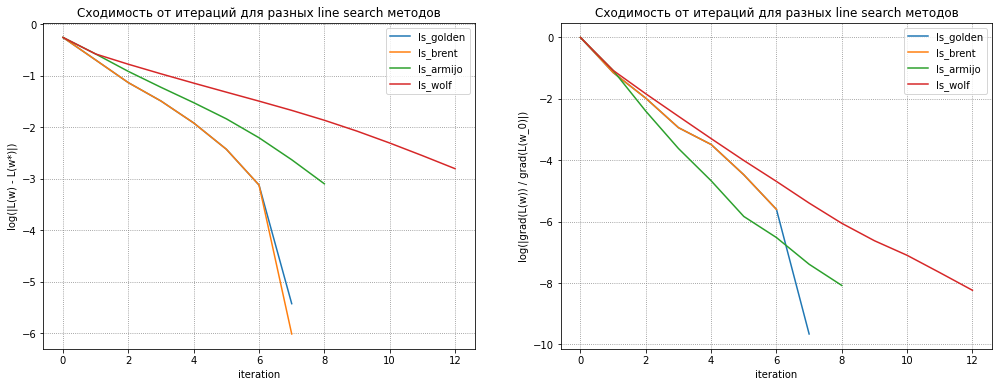

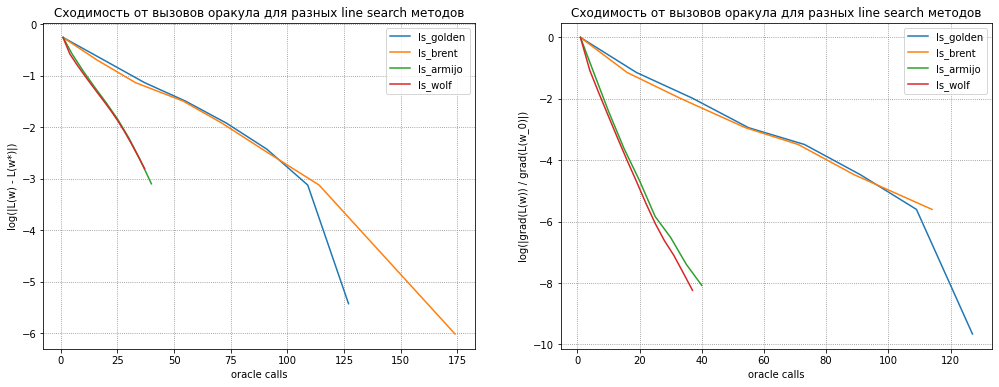

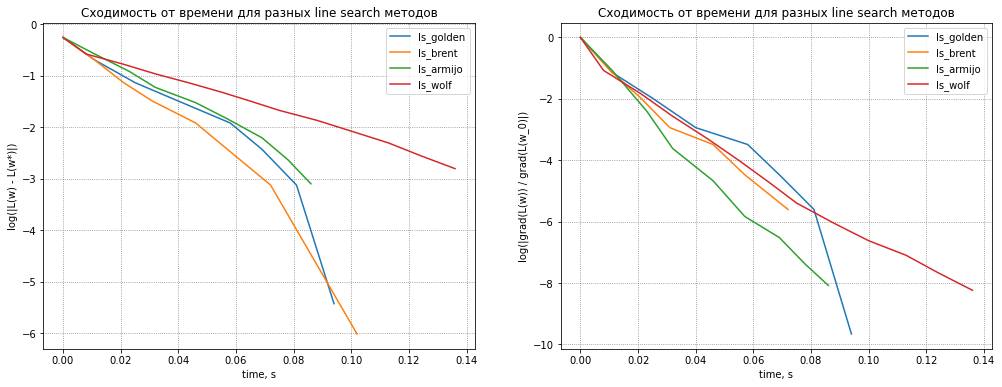

In [27]:
six_plots(res, true_val3, names=names, compare_name="line search методов")

В данном эксперименте метод Ньютона с Брэнтом и золотым сечением сошёлся за 7 итераций, остальным стратегиям потребовалось не более 12 итераций. Брэнт и золотое сечение достигли точности в 5 знаков после запятой. Зато армихо и вульфу потребовалось менее 50 вызовов оракула. Графики соответствуют квадратичной сходимости.

Таким образом, метод Ньютона сходится довольно быстро в сравнении с методом GD. Однако, могут появиться большие затраты на память из-за гессиана.

## Пункт 6 
Реализовать Hessian-free Newton для решения логистической
регресии, т.е. метод ньютона, в котором решение системы $H_k d = g_k$ производится с помощью метода сопряженных градиентов + неточно,
при этом точность решения увеличивается в процессе оптимизации + в
сопряженных градиентах матрица $H_k$ явно не строится, а только делается
умножение гессиана на вектор.

In [28]:
oracle = oracle1
line_search_methods = [line_search_golden(), line_search_brent(),
                       line_search_armijo(), line_search_wolf()]
names = ["ls_golden", "ls_brent", "ls_armijo", "ls_wolf"]

w0 = np.zeros(oracle.X.shape[1]).reshape(-1, 1)
# w0 = np.random.randn(oracle.X.shape[1]).reshape(-1, 1)
# w0 = np.ones(oracle.X.shape[1]).reshape(-1, 1)

res = []
for i in range(len(line_search_methods)):
    start = time()
    print(names[i], "+ HFN + CG: START")
    print()
    optimize = hfn_optimize()
    w_my = optimize(oracle, w0, line_search_methods[i],
                    eta1, max_iter=2*oracle.X.shape[1])
    
    vals = optimize.values
    iters = optimize.iterations
    or_calls = optimize.oracle_calls
    times = optimize.times
    grads = optimize.grads
    
    res.append([w_my, vals, iters, or_calls, times, grads])
    print(names[i], "+ HFN + CG: END")
    print("CE value:", oracle.value(w_my).squeeze())
    print("Total oracle calls: ", or_calls[-1])
    print("Time: ", time() - start, "sec")
    print("----------------------------------------------------------")
    print()

ls_golden + HFN + CG: START

iteration: 0
value of CE: 0.6931471605599454
norm_grad_sq: 0.5004468124338854
alpha 1.133220770720017

iteration: 1
value of CE: 0.5331370976843978
norm_grad_sq: 0.04242864320193006
alpha 1.0688428511482557

iteration: 2
value of CE: 0.3933974012758945
norm_grad_sq: 0.024414601201232906
alpha 1.0442526739968507

iteration: 3
value of CE: 0.3814554534779732
norm_grad_sq: 0.002597600666022138
alpha 1.2881712366703515

iteration: 4
value of CE: 0.32401871626328743
norm_grad_sq: 0.0014040624807375986
alpha 1.179805070947145

iteration: 5
value of CE: 0.3125760299864707
norm_grad_sq: 9.591887838065485e-05
alpha 1.2169967592918178

iteration: 6
value of CE: 0.3000896878697848
norm_grad_sq: 4.6591020572979506e-05
alpha 1.2237933170985902

iteration: 7
value of CE: 0.2987865465344774
norm_grad_sq: 8.671231840986976e-07
alpha 1.6540490806806025

iteration: 8
value of CE: 0.2980897787429453
norm_grad_sq: 1.1806354399047685e-06
alpha 1.3525491562421128

iteration: 9
v

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


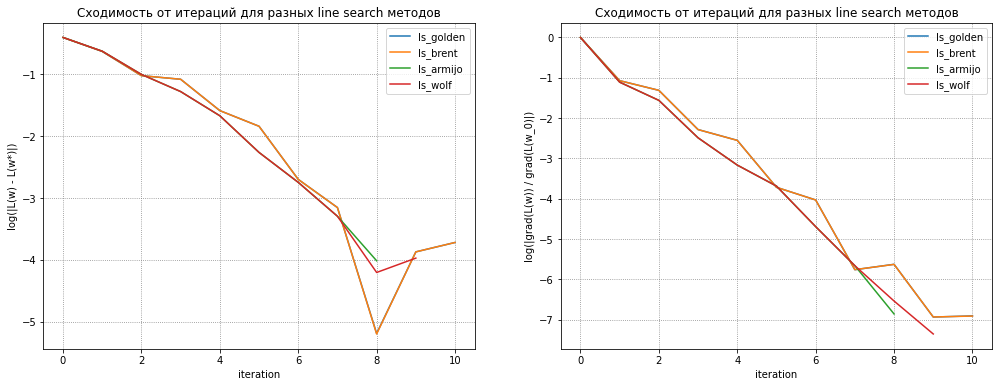

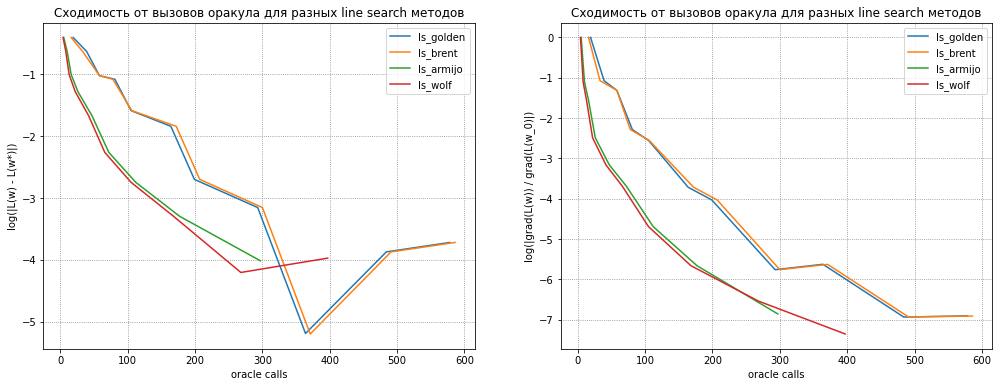

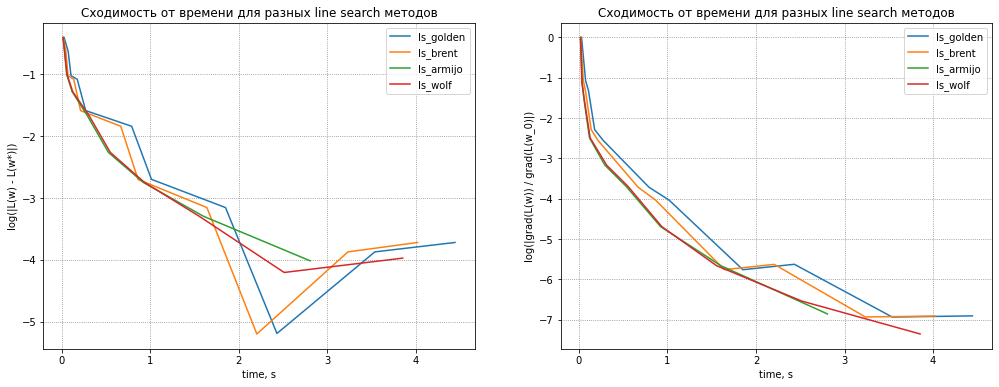

In [29]:
six_plots(res, true_val1, names=names, compare_name="line search методов")

Всем методам потребовалось не более 10 итераций, 600 обращений к оракулу. Времени поребовалось не более 4 сек. Для всех стратегий итоговые графики получились схожими.

In [30]:
oracle = oracle2
line_search_methods = [line_search_golden(), line_search_brent(),
                       line_search_armijo(), line_search_wolf()]
names = ["ls_golden", "ls_brent", "ls_armijo", "ls_wolf"]

w0 = np.zeros(oracle.X.shape[1]).reshape(-1, 1)
# w0 = np.random.randn(120).reshape(-1, 1)
# w0 = np.ones(oracle.X.shape[1]).reshape(-1, 1)

res = []
for i in range(len(line_search_methods)):
    start = time()
    print(names[i], "+ HFN + CG: START")
    print()
    optimize = hfn_optimize()
    w_my = optimize(oracle, w0, line_search_methods[i],
                    eta1, max_iter=2*oracle.X.shape[1])
    
    vals = optimize.values
    iters = optimize.iterations
    or_calls = optimize.oracle_calls
    times = optimize.times
    grads = optimize.grads
    
    res.append([w_my, vals, iters, or_calls, times, grads])
    print(names[i], "+ HFN + CG: END")
    print("CE value:", oracle.value(w_my).squeeze())
    print("Total oracle calls: ", or_calls[-1])
    print("Time: ", time() - start, "sec")
    print("----------------------------------------------------------")
    print()

ls_golden + HFN + CG: START

iteration: 0
value of CE: 0.6931471605599454
norm_grad_sq: 0.8428883716334497
alpha 1.8157961044377082

iteration: 1
value of CE: 0.297038886967537
norm_grad_sq: 0.057554265480536215
alpha 1.2085957518296393

iteration: 2
value of CE: 0.14921543371410206
norm_grad_sq: 0.018210219261280094
alpha 1.6498485769495126

iteration: 3
value of CE: 0.12094477315595561
norm_grad_sq: 0.002982234618464959
alpha 2.332423910667204

iteration: 4
value of CE: 0.08413879051889893
norm_grad_sq: 8.13362856565464e-05
alpha 0.9824708085007723

iteration: 5
value of CE: 0.07649878832307679
norm_grad_sq: 8.72227575236626e-06
alpha 1.3771393333935176

iteration: 6
value of CE: 0.07549553831197856
norm_grad_sq: 1.5476682486119001e-07
alpha 0.8071306691301217

ls_golden + HFN + CG: END
CE value: 0.07531967034544138
Total oracle calls:  152
Time:  0.15000486373901367 sec
----------------------------------------------------------

ls_brent + HFN + CG: START

iteration: 0
value of CE: 

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


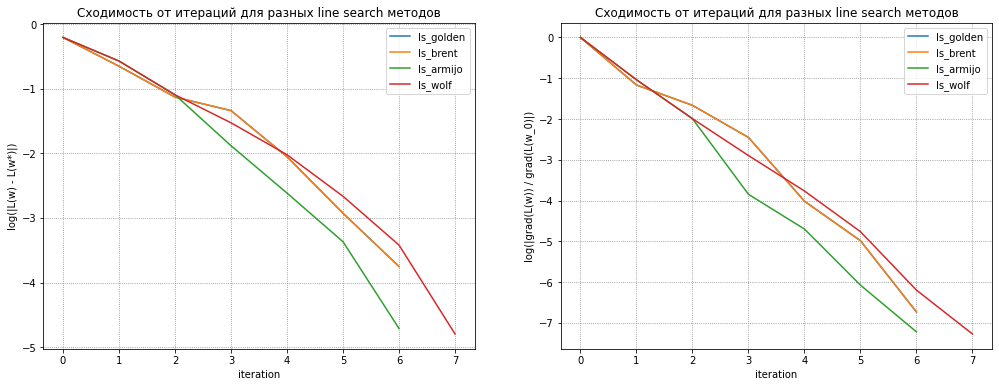

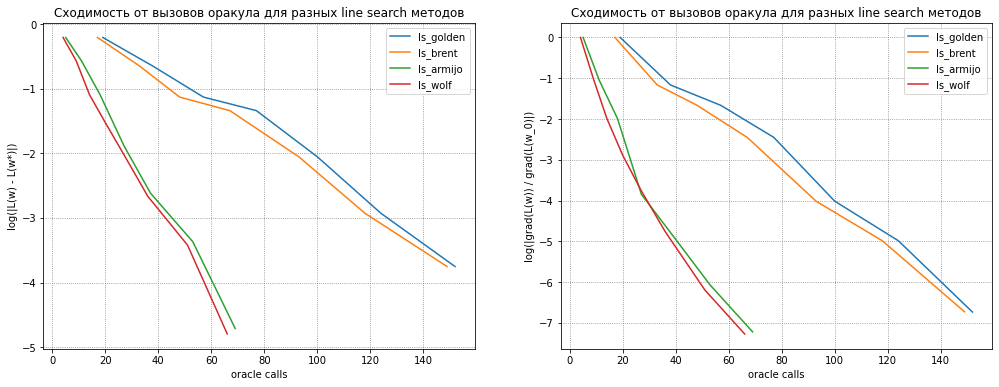

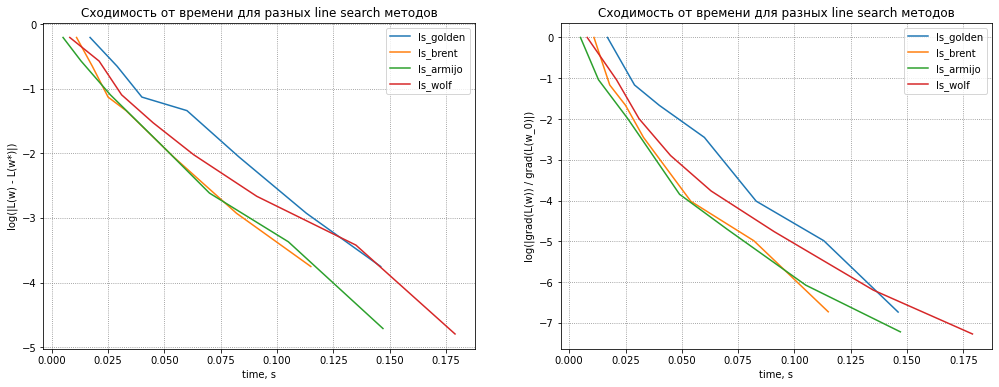

In [31]:
six_plots(res, true_val2, names=names, compare_name="line search методов")

Всем методам потребовалось не более 7 итераций. Для разных методов графики отличаются не сильно. Метод золотого сечения работал дольше в сравнении с остальными. Также Брэнту и золотому сечению потребовалось более 120 вызовов оракула, в то время как остальным не больше 80.

In [32]:
oracle = oracle3
line_search_methods = [line_search_golden(), line_search_brent(),
                       line_search_armijo(), line_search_wolf()]
names = ["ls_golden", "ls_brent", "ls_armijo", "ls_wolf"]

w0 = np.zeros(oracle.X.shape[1]).reshape(-1, 1)
# w0 = np.random.randn(oracle.X.shape[1]).reshape(-1, 1)
# w0 = np.ones(oracle.X.shape[1]).reshape(-1, 1)

res = []
for i in range(len(line_search_methods)):
    start = time()
    print(names[i], "+ HFN + CG: START")
    print()
    optimize = hfn_optimize()
    w_my = optimize(oracle, w0, line_search_methods[i],
                    eta1, max_iter=2*oracle.X.shape[1])
    
    vals = optimize.values
    iters = optimize.iterations
    or_calls = optimize.oracle_calls
    times = optimize.times
    grads = optimize.grads
    
    res.append([w_my, vals, iters, or_calls, times, grads])
    print(names[i], "+ HFN + CG: END")
    print("CE value:", oracle.value(w_my).squeeze())
    print("Total oracle calls: ", or_calls[-1])
    print("Time: ", time() - start, "sec")
    print("----------------------------------------------------------")
    print()

ls_golden + HFN + CG: START

iteration: 0
value of CE: 0.6931471605599454
norm_grad_sq: 0.15192985210126794
alpha 14.995799496268914

iteration: 1
value of CE: 0.029154841523081294
norm_grad_sq: 2.156377788730067e-06
alpha 14.995799496268914

iteration: 2
value of CE: 0.002658742109340794
norm_grad_sq: 1.7533150500213444e-06
alpha 1.0358516665346724

ls_golden + HFN + CG: END
CE value: 0.0020991581059221338
Total oracle calls:  58
Time:  0.03999948501586914 sec
----------------------------------------------------------

ls_brent + HFN + CG: START

iteration: 0
value of CE: 0.6931471605599454
norm_grad_sq: 0.15192985210126794
alpha 875.8424126104948

iteration: 1
value of CE: 0.001405782109547133
norm_grad_sq: 8.840983683981479e-07
alpha 3.0565967007247448

ls_brent + HFN + CG: END
CE value: 7.778824858065858e-06
Total oracle calls:  62
Time:  0.030998706817626953 sec
----------------------------------------------------------

ls_armijo + HFN + CG: START

iteration: 0
value of CE: 0.693

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


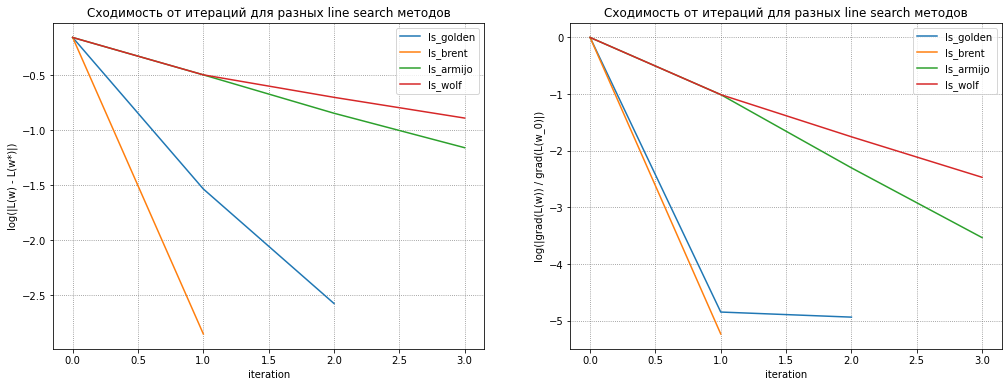

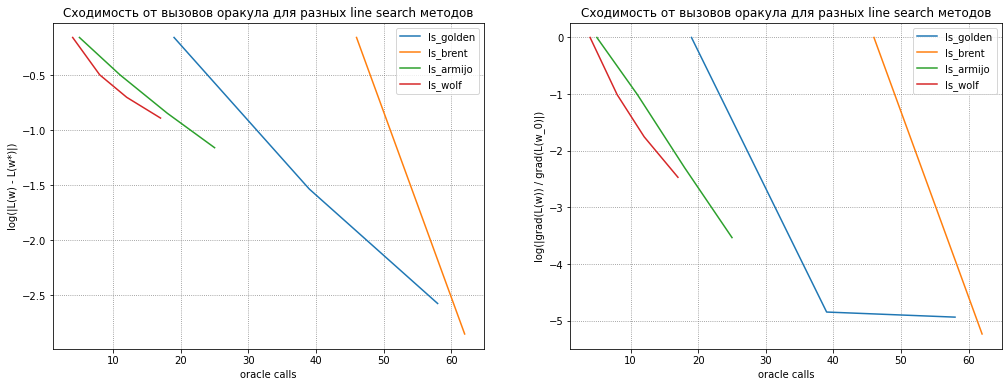

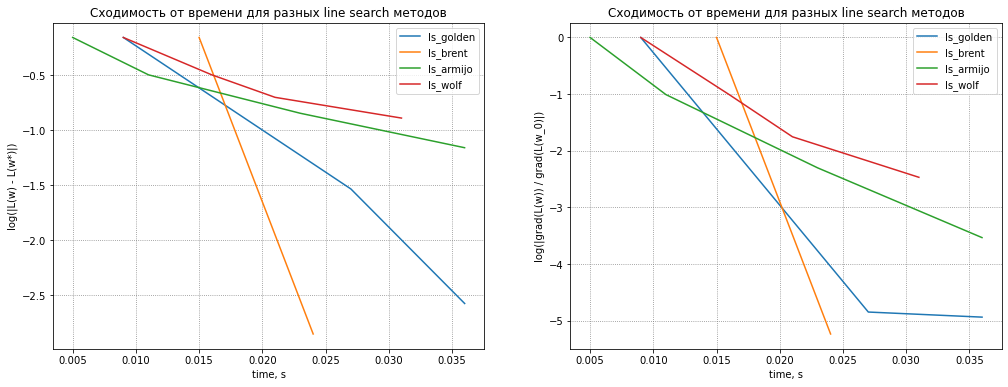

In [33]:
six_plots(res, true_val3, names=names, compare_name="line search методов")

На данном датасете HFN отработал довольно быстро. Мне кажется, что странность графиков можно объяснить простотой датасета. Методам потребовалось максимум 3 итерации до сходимости и не более 60 обращений к оракулу.

Таким образом, Hessian Free Newton метод, обладающий достоинствами метода Ньбтона, но и работающий по памяти примерно как GD.

## Стратегии выбора точности в Hessian-Free Newton
изучить зависимость от стратегии выбора точности, с которой решается
задача в методе CG. В качестве методов линейного поиска возьмём армихо и вульфа.

$\eta_1 = min(0.5, \sqrt{||\nabla f_k||})$

$\eta_2 = min(0.5, ||\nabla f_k||)$

$\eta_3 = 0.1$

$\eta_4 = 0.5$

$\eta_5 = 0.9$

In [34]:
etas = [eta1, eta2, eta3, eta4, eta5]
eta_names = ["eta1", "eta2", "eta3", "eta4", "eta5"]

In [35]:
# HFN + armijo + different etas + a1a
oracle = oracle1
w0 = np.zeros(oracle.X.shape[1]).reshape(-1, 1)
# w0 = np.random.randn(120).reshape(-1, 1)
# w0 = np.ones(oracle.X.shape[1]).reshape(-1, 1)

res = []
for i in range(len(etas)):
    start = time()
    print(eta_names[i], "+ HFN + CG: START")
    print()
    optimize = hfn_optimize()
    w_my = optimize(oracle, w0, line_search_armijo(),
                    etas[i], max_iter=2*oracle.X.shape[1])
    
    vals = optimize.values
    iters = optimize.iterations
    or_calls = optimize.oracle_calls
    times = optimize.times
    
    res.append([w_my, vals, iters, or_calls, times])
    print(eta_names[i], "+ HFN + CG: END")
    print("CE value:", oracle.value(w_my).squeeze())
    print("Total oracle calls: ", or_calls[-1])
    print("Time: ", time() - start, "sec")
    print("----------------------------------------------------------")
    print()

eta1 + HFN + CG: START

iteration: 0
value of CE: 0.6931471605599454
norm_grad_sq: 0.5004468124338854
alpha 1

iteration: 1
value of CE: 0.5349965691769173
norm_grad_sq: 0.03894439177024585
alpha 1

iteration: 2
value of CE: 0.39785342395990053
norm_grad_sq: 0.013773755048288941
alpha 1

iteration: 3
value of CE: 0.35078479812319396
norm_grad_sq: 0.0016210785463955397
alpha 1

iteration: 4
value of CE: 0.3194990454547351
norm_grad_sq: 0.00034161362120688416
alpha 1

iteration: 5
value of CE: 0.303554060068359
norm_grad_sq: 0.00010297527074079534
alpha 1

iteration: 6
value of CE: 0.29987914320667797
norm_grad_sq: 1.014894668376024e-05
alpha 1

iteration: 7
value of CE: 0.29859173978262515
norm_grad_sq: 1.0896053739474741e-06
alpha 2

iteration: 8
value of CE: 0.2979863761928429
norm_grad_sq: 6.920275899952397e-08
alpha 1

eta1 + HFN + CG: END
CE value: 0.29791465170980447
Total oracle calls:  297
Time:  2.8019983768463135 sec
----------------------------------------------------------



For eta1: CE value: 0.298; oracle calls: 297; iter_num:  8; time: 2.798
For eta2: CE value: 0.298; oracle calls: 652; iter_num:  7; time: 6.548
For eta3: CE value: 0.298; oracle calls: 225; iter_num:  7; time: 2.103
For eta4: CE value: 0.298; oracle calls: 221; iter_num: 14; time: 1.890
For eta5: CE value: 0.298; oracle calls: 326; iter_num: 36; time: 1.976


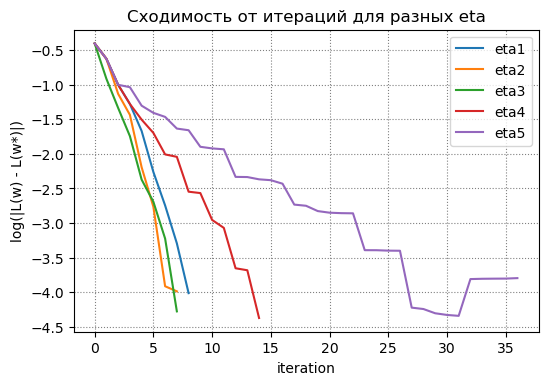

In [36]:
one_plot(res, true_val1, names=list(map(lambda x: str(x + 1),\
                                        range(len(etas)))), par="eta")

На данном датасете результат с $\eta_5$ потребовалось больше итераций (30), чем с другими. С $\eta_2$ потребовалось больше вызовов оракула (около 600) и около 5 сек, это больше чем потребовалось другим $\eta_i$. Со всеми $\eta_i$ были найдены точки оптимума, в которых функция L достигает значения 0.298.

In [37]:
# HFN + wolf + different etas + a1a

oracle = oracle1
w0 = np.zeros(oracle.X.shape[1]).reshape(-1, 1)
# w0 = np.random.randn(120).reshape(-1, 1)
# w0 = np.ones(oracle.X.shape[1]).reshape(-1, 1)

res = []
for i in range(len(etas)):
    start = time()
    print(eta_names[i], "+ HFN + CG: START")
    print()
    optimize = hfn_optimize()
    w_my = optimize(oracle, w0, line_search_wolf(),
                    etas[i], max_iter=2*oracle.X.shape[1])
    
    vals = optimize.values
    iters = optimize.iterations
    or_calls = optimize.oracle_calls
    times = optimize.times
    
    res.append([w_my, vals, iters, or_calls, times])
    print(eta_names[i], "+ HFN + CG: END")
    print("CE value:", oracle.value(w_my).squeeze())
    print("Total oracle calls: ", or_calls[-1])
    print("Time: ", time() - start, "sec")
    print("----------------------------------------------------------")
    print()

eta1 + HFN + CG: START

iteration: 0
value of CE: 0.6931471605599454
norm_grad_sq: 0.5004468124338854
alpha 1.0

iteration: 1
value of CE: 0.5349965691769173
norm_grad_sq: 0.03894439177024585
alpha 1.0

iteration: 2
value of CE: 0.39785342395990053
norm_grad_sq: 0.013773755048288941
alpha 1.0

iteration: 3
value of CE: 0.35078479812319396
norm_grad_sq: 0.0016210785463955397
alpha 1.0

iteration: 4
value of CE: 0.3194990454547351
norm_grad_sq: 0.00034161362120688416
alpha 1.0

iteration: 5
value of CE: 0.303554060068359
norm_grad_sq: 0.00010297527074079534
alpha 1.0

iteration: 6
value of CE: 0.29987914320667797
norm_grad_sq: 1.014894668376024e-05
alpha 1.0

iteration: 7
value of CE: 0.29859173978262515
norm_grad_sq: 1.0896053739474741e-06
alpha 1.0

iteration: 8
value of CE: 0.29814603639485165
norm_grad_sq: 1.4486617480428911e-07
alpha 1.0

iteration: 9
value of CE: 0.29797632678373664
norm_grad_sq: 2.204990621865919e-08
alpha 1.0

eta1 + HFN + CG: END
CE value: 0.297912992838583
Tota

For eta1: CE value: 0.298; oracle calls: 397; iter_num:  9; time: 3.975
For eta2: CE value: 0.298; oracle calls: 899; iter_num:  8; time: 9.390
For eta3: CE value: 0.298; oracle calls: 276; iter_num:  8; time: 2.765
For eta4: CE value: 0.298; oracle calls: 206; iter_num: 14; time: 1.728
For eta5: CE value: 0.298; oracle calls: 265; iter_num: 32; time: 1.938


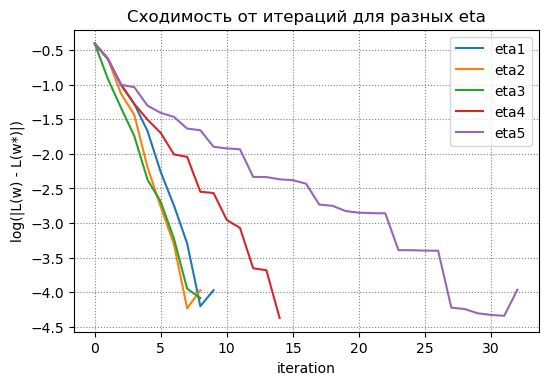

In [38]:
one_plot(res, true_val1, names=list(map(lambda x: str(x + 1),\
                                        range(len(etas)))), par="eta")

От выбора другого метода линейного поиска мало что изменилось.

In [39]:
# HFN + armijo + different etas + bc dataset

oracle = oracle2
w0 = np.zeros(oracle.X.shape[1]).reshape(-1, 1)
# w0 = np.random.rand(120).reshape(-1, 1)
# w0 = np.ones(oracle.X.shape[1]).reshape(-1, 1)

res = []
for i in range(len(etas)):
    start = time()
    print(eta_names[i], "+ HFN + CG: START")
    print()
    optimize = hfn_optimize()
    w_my = optimize(oracle, w0, line_search_armijo(),
                    etas[i], max_iter=2*oracle.X.shape[1])
    
    vals = optimize.values
    iters = optimize.iterations
    or_calls = optimize.oracle_calls
    times = optimize.times
    
    res.append([w_my, vals, iters, or_calls, times])
    print(eta_names[i], "+ HFN + CG: END")
    print("CE value:", oracle.value(w_my).squeeze())
    print("Total oracle calls: ", or_calls[-1])
    print("Time: ", time() - start, "sec")
    print("----------------------------------------------------------")
    print()

eta1 + HFN + CG: START

iteration: 0
value of CE: 0.6931471605599454
norm_grad_sq: 0.8428883716334497
alpha 1

iteration: 1
value of CE: 0.34210396242424695
norm_grad_sq: 0.07733497726986324
alpha 1

iteration: 2
value of CE: 0.1554117605614487
norm_grad_sq: 0.008580151166925109
alpha 2

iteration: 3
value of CE: 0.08837205941161955
norm_grad_sq: 0.00011972398051579255
alpha 1

iteration: 4
value of CE: 0.0777359751976853
norm_grad_sq: 1.682357779981576e-05
alpha 1

iteration: 5
value of CE: 0.07574577737762755
norm_grad_sq: 7.085176297587914e-07
alpha 1

iteration: 6
value of CE: 0.07533815887110203
norm_grad_sq: 5.0618312715736406e-08
alpha 1

eta1 + HFN + CG: END
CE value: 0.07531897070593693
Total oracle calls:  69
Time:  0.14000296592712402 sec
----------------------------------------------------------

eta2 + HFN + CG: START

iteration: 0
value of CE: 0.6931471605599454
norm_grad_sq: 0.8428883716334497
alpha 1

iteration: 1
value of CE: 0.34210396242424695
norm_grad_sq: 0.0773349

For параметровeta1: CE value: 0.075; oracle calls:  69; iter_num:  6; time: 0.137
For параметровeta2: CE value: 0.075; oracle calls:  81; iter_num:  6; time: 0.178
For параметровeta3: CE value: 0.075; oracle calls:  69; iter_num:  6; time: 0.137
For параметровeta4: CE value: 0.075; oracle calls:  67; iter_num:  8; time: 0.099
For параметровeta5: CE value: 0.075; oracle calls: 106; iter_num: 16; time: 0.170


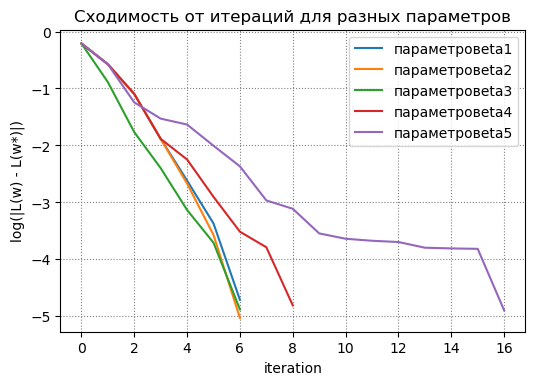

In [40]:
one_plot(res, true_val2, eta_names)

На другом датасете положение аналогично.